### Imports

In [1]:
# RDKit: https://www.rdkit.org/
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, MACCSkeys
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors

# Pandas: https://pandas.pydata.org
import pandas as pd

# NumPy: https://numpy.org/doc/stable/release.html
import numpy as np

# Scikit-learn: https://scikit-learn.org
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedKFold, 
                                     RandomizedSearchCV)
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin

# XGBoost: https://xgboost.ai/
import xgboost as xgb

# SHAP: https://github.com/slundberg/shap
import shap

# XSmiles: https://github.com/mahmoudnafifi/xsmiles
import xsmiles

# JSON: https://docs.python.org/3/library/json.html
import json

# Matplotlib: https://matplotlib.org/
import matplotlib.pyplot as plt

# SciPy: https://www.scipy.org/
from scipy.stats import uniform

In [2]:
file_path = 'udataset.xlsx'
#file_path = "new.xlsx"

In [3]:
df = pd.read_excel(file_path)
df.head()

,Substance,Substance_lower,CAS_number,Smiles_code,Additional info,Irritation,Source
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN


### Descriptor calculation

In [4]:
def calculate_descriptors(df):
    # List to hold descriptor data for each row
    descriptor_data = []
    
    for smiles in df['Smiles_code']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Append a dictionary of None values for all descriptors if SMILES is invalid
            descriptor_data.append({desc[0]: None for desc in Descriptors.descList})
            continue
        
        descriptors = {}
        for descriptor, function in Descriptors.descList:
            try:
                descriptors[descriptor] = function(mol)
            except Exception:
                descriptors[descriptor] = None
        
        descriptor_data.append(descriptors)
    
    # Create a DataFrame for descriptor values with the same index as the original DataFrame
    descriptors_df = pd.DataFrame(descriptor_data, index=df.index)
    
    # Concatenate original DataFrame with descriptor DataFrame
    df = pd.concat([df, descriptors_df], axis=1)
    
    return df

In [5]:
# Function to calculate fingerprint descriptors for each row
def calculate_fingerprint(df, radius=2, n_bits=1024):
    # List to hold fingerprint data for each row
    fingerprint_data = []
    
    for smiles in df['Smiles_code']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            fingerprint_data.append([None] * n_bits)  # Append None for invalid SMILES
            continue
        
        # Calculate the Morgan fingerprint (radius 2, 1024 bits by default)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        
        # Convert fingerprint to a list of bits
        fingerprint_data.append(list(fingerprint))
    
    # Create a DataFrame for fingerprint values
    fingerprint_df = pd.DataFrame(fingerprint_data, columns=[f'Bit_{i}' for i in range(n_bits)])
    
    # Concatenate original dataframe with fingerprint dataframe
    df = pd.concat([df, fingerprint_df], axis=1)
    
    return df

In [6]:
df = calculate_descriptors(df)
#df = calculate_fingerprint(df)

[15:23:20] WARNING: not removing hydrogen atom without neighbors
[15:23:20] WARNING: not removing hydrogen atom without neighbors
[15:23:20] WARNING: not removing hydrogen atom without neighbors


In [7]:
df.head()

,Substance,Substance_lower,CAS_number,Smiles_code,Additional info,Irritation,Source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf,9.768009,9.768009,0.750000,...,0,0,0,0,0,0,0,0,3,0
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN,10.535393,10.535393,0.116191,...,0,0,0,0,0,0,0,0,0,0
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN,3.350347,3.350347,1.167500,...,0,0,0,0,0,0,0,0,1,0
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN,8.629773,8.629773,0.329353,...,0,0,0,0,0,0,0,0,0,0
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN,3.974575,3.974575,0.767315,...,0,0,0,0,0,0,0,0,0,0


### Data Preprocessing

In [8]:
columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "Smiles_code", "Additional info", "Source"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,I,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,I,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,I,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,I,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,I,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [9]:
total_rows = len(df)
nan_columns = df.columns[df.isnull().any()].tolist()
nan_info = df[nan_columns].isnull().sum()
nan_percentage = (nan_info / total_rows) * 100
nan_info = pd.DataFrame({'NaN Count': nan_info, 'NaN Percentage': nan_percentage})
print(nan_info)

                     NaN Count  NaN Percentage
MaxPartialCharge             4        0.896861
MinPartialCharge             4        0.896861
MaxAbsPartialCharge          4        0.896861
MinAbsPartialCharge          4        0.896861
BCUT2D_MWHI                 35        7.847534
BCUT2D_MWLOW                35        7.847534
BCUT2D_CHGHI                35        7.847534
BCUT2D_CHGLO                35        7.847534
BCUT2D_LOGPHI               35        7.847534
BCUT2D_LOGPLOW              35        7.847534
BCUT2D_MRHI                 35        7.847534
BCUT2D_MRLOW                35        7.847534


In [10]:
columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)

In [11]:
# Calculate the percentage of zeros for each column
zero_percentage = (df.isin([0]).sum() / len(df)) * 100

In [12]:
columns_to_keep = zero_percentage[zero_percentage <= 90].index
df = df[columns_to_keep]
len(columns_to_keep)

132

In [13]:
def drop_columns(df):
    columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "Smiles_code", "Additional info", "Source"]

    #   Drop the columns using the drop() method with axis=1 (columns)
    df = df.drop(columns_to_drop, axis=1)

    columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

    # Drop the columns using the drop() method with axis=1 (columns)
    df = df.drop(columns_to_drop, axis=1)

    # Calculate the percentage of zeros for each column
    zero_percentage = (df.isin([0]).sum() / len(df)) * 100
    columns_to_keep = zero_percentage[zero_percentage <= 90].index
    df = df[columns_to_keep]

    return df

In [14]:
# Count the number of rows before dropping NaN values
num_rows_before = df.shape[0]

# Drop rows with NaN values
df.dropna(inplace=True)

# Count the number of rows after dropping NaN values
num_rows_after = df.shape[0]

# Calculate the number of rows dropped
num_rows_dropped = num_rows_before - num_rows_after

print("Number of rows dropped:", num_rows_dropped)

Number of rows dropped: 4


In [15]:
def detect_outliers(df):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (df < lower_bound) | (df > upper_bound)
    
    # Replace outliers with median
    median_values = df.median(axis=1)
    df = df.where(~outlier_mask, median_values, axis=0)


    outliers = df[outlier_mask.any(axis=1)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers detected: {num_outliers}")

    return df

In [16]:

df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})
df.head()

/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_92525/744444035.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})


,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_amide,fr_aniline,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_unbrch_alkane
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,0,3
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,1,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,1,0,0,1
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df = detect_outliers(df)

Number of outliers detected: 435


/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_92525/1934217254.py:20: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.where(~outlier_mask, median_values, axis=0)


In [18]:

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
normalized_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df = pd.DataFrame(normalized_data, columns=df.columns)

df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_amide,fr_aniline,fr_aryl_methyl,fr_benzene,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_unbrch_alkane
0,1.0,0.648191,0.648191,0.790665,0.484550,0.378529,0.466241,0.205457,0.174775,0.206167,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.026083
1,1.0,0.699113,0.699113,0.122491,0.417018,0.713980,0.694891,0.371992,0.330948,0.373260,...,0.0,0.0,0.0,0.178966,0.0,0.0,0.000000,0.0,0.0,0.000000
2,1.0,0.000000,0.000000,0.000000,0.529035,0.417235,0.459854,0.273566,0.248858,0.272784,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.178966,0.0,0.0,0.000000
3,1.0,0.572659,0.572659,0.347211,0.439730,0.619348,0.650299,0.283215,0.241706,0.284191,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,1.0,0.263747,0.263747,0.808919,0.486395,0.480844,0.000000,0.246201,0.211988,0.247030,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [19]:

def feature_selection(df):
    nonzero_thrd=0.01
    cor_thrd=0.9
    print(f"Original shape of data: {df.shape}")
    
    # Step 1: Remove features with low variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]
    print(f"Removed {df.shape[1] - nonzero_df.shape[1]} features with variance <= {nonzero_thrd}")
    
    # Step 2: Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    print(f"Removed {len(to_drop)} highly correlated features with correlation > {cor_thrd}")
    
    # Step 3: Return the cleaned dataset
    cleaned_df = nonzero_df.drop(to_drop, axis=1)
    print(f"Final shape of data: {cleaned_df.shape}")
    return cleaned_df


df = feature_selection(df)
df.head()

Original shape of data: (442, 132)
Removed 8 features with variance <= 0.01
Removed 25 highly correlated features with correlation > 0.9
Final shape of data: (442, 99)


,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,FpDensityMorgan1,FpDensityMorgan2,AvgIpc,...,fr_allylic_oxid,fr_amide,fr_aniline,fr_aryl_methyl,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_unbrch_alkane
0,1.0,0.648191,0.790665,0.484550,0.378529,0.466241,0.205457,0.546053,0.758621,0.488390,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.026083
1,1.0,0.699113,0.122491,0.417018,0.713980,0.694891,0.371992,0.515789,0.657471,0.585415,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,1.0,0.000000,0.000000,0.529035,0.417235,0.459854,0.273566,0.596491,0.758621,0.435879,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.178966,0.0,0.0,0.000000
3,1.0,0.572659,0.347211,0.439730,0.619348,0.650299,0.283215,0.614833,0.758621,0.504577,...,0.079749,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,1.0,0.263747,0.808919,0.486395,0.480844,0.000000,0.246201,0.818421,0.910345,0.508828,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


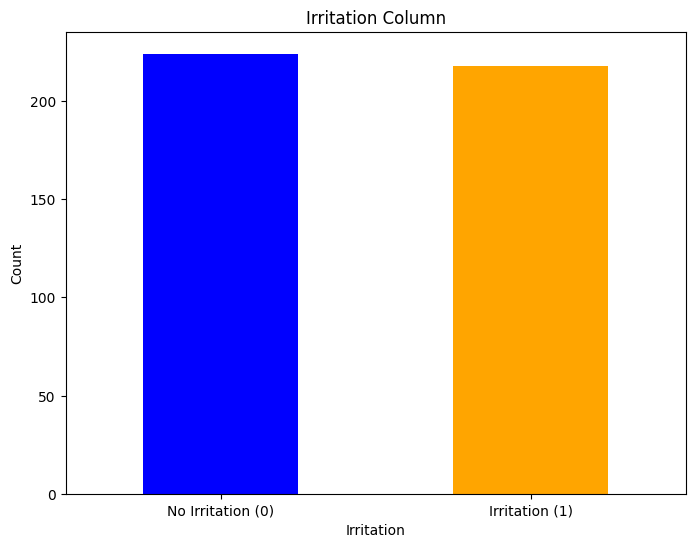

In [20]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

### Train Test Datasets

In [27]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [223]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (353, 98)
Shape of X_test: (89, 98)
Shape of y_train: (353,)
Shape of y_test: (89,)


In [48]:
y_train

232    0.0
69     1.0
306    0.0
318    0.0
270    0.0
      ... 
5      1.0
439    1.0
113    1.0
58     1.0
49     1.0
Name: Irritation, Length: 353, dtype: float64

### print_score

In [154]:
# Function to print evaluation metrics and cross-validation results
def print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search=None, y_prob_test=None):
    # Evaluate the model on training data
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print("Training Accuracy:", train_accuracy)
    print("Training Classification Report:")
    print(classification_report(y_train, y_pred_train))
    print("Training Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred_train))
    print("\n")  # Separate training and testing output
    
    # Evaluate the model on testing data
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Testing Accuracy:", test_accuracy)
    print("Testing Classification Report:")
    print(classification_report(y_test, y_pred_test))
    print("Testing Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))

    roc_auc = roc_auc_score(y_test, y_prob_test)
    print(f"ROC-AUC Score on Test Set: {roc_auc:.4f}")
        
    # If GridSearchCV was used, print cross-validation results
    if grid_search:
        print("\nGridSearchCV Summary:")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_score(y_train, y_pred_train, y_test, y_pred_test):    
    # Evaluate the model on testing data
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Print Testing results
    print("\nTesting Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1:.4f}")


## XGBoost

In [191]:
def xgboost(X_train, X_test, y_train, y_test):
    param_grid = {
        'learning_rate': [0.01, 0.05],  # Lower learning rate
        'max_depth': [3],  # Shallower trees
        'n_estimators': [100, 150],  # More boosting rounds
        'min_child_weight': [4, 5],  # Higher value to reduce overfitting
        'subsample': [0.5, 0.6],  # Lower subsampling
        'colsample_bytree': [0.5, 0.6],  # Fewer features per tree
        'reg_alpha': [0.5, 1.0],  # Stronger L1 regularization
        'reg_lambda': [2.0, 3.0],  # Stronger L2 regularization
    }

    # Create an instance of the XGBClassifier
    final_model = xgb.XGBClassifier()

    """

    # Set up GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    ## Use early stopping with the best parameters
    final_model = xgb.XGBClassifier(
        **best_params, 
        early_stopping_rounds=10,
        eval_metric="logloss"
    )
        """
    # Fit the model using a validation set for early stopping
    final_model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_test, y_test)], 
        verbose=False
    )
    
    # Make predictions
    y_pred_test = final_model.predict(X_test)
    y_pred_train = final_model.predict(X_train)

    # Get predicted probabilities
    y_prob_test = final_model.predict_proba(X_test)[:, 1]

    #print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search, y_prob_test)
    print_score(y_train, y_pred_train, y_test, y_pred_test)
    return final_model

In [236]:
model = xgboost(X_train, X_test, y_train, y_test)


Testing Results:
Accuracy: 0.8315
Precision: 0.8696
Recall: 0.8163
F1-Score: 0.8421


In [157]:
def feature_selection(features, model):
    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    # Calculate feature importance
    vals = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

    # Extract top important features
    top_features = feature_importance['col_name'].head(features).tolist()

    # Filter training and validation data to include only top important features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    return X_train_selected, X_test_selected

In [237]:
X_train_selected, X_test_selected = feature_selection(50, model)
model = xgboost(X_train_selected, X_test_selected, y_train, y_test)


Testing Results:
Accuracy: 0.8427
Precision: 0.8889
Recall: 0.8163
F1-Score: 0.8511


In [ ]:

X100 = shap.utils.sample(X, 100)
sample_ind = 20
explainer_xgb = shap.Explainer(model, X100)
shap_values_xgb = explainer_xgb(X)
shap.plots.waterfall(shap_values_xgb[sample_ind], max_display=14)


In [ ]:
#absolutna hodnota aj kladnej aj zapornej
shap.plots.bar(shap_values_xgb)

In [ ]:
#kladne iba
shap.plots.bar(shap_values_xgb.abs.max(0))

In [ ]:
#Distribucia pre zložitejšie prípady 
shap.plots.beeswarm(shap_values_xgb)

In [ ]:
shap.plots.heatmap(shap_values_xgb[:1000])

### order descriptors

In [46]:
def order_descriptors(shap_values, df):
    # Convert SHAP values to absolute values and calculate mean
    abs_shap_values = np.abs(shap_values)
    mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

    # Get column names from df
    column_names = df.columns

    # Calculate mean importance across all samples
    mean_importance = np.mean(mean_abs_shap_values, axis=0)

    # Combine feature names with mean SHAP values
    feature_importance_df = pd.DataFrame({'Feature': column_names, 'Mean_Shap_Value': mean_importance})

    # Sort features by mean importance in descending order
    sorted_features = feature_importance_df.sort_values(by='Mean_Shap_Value', ascending=False)


    return  sorted_features

In [47]:
def feature_selection(features, model):
    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)
    shap_values = np.swapaxes(np.swapaxes(shap_values, 0, 2), 1, 2)

    sorted_features = order_descriptors(shap_values, X_train)
    print(sorted_features.head(features))

    top_features = sorted_features["Feature"].head(features).tolist()

    X_train_selected =  X_train[top_features]
    X_test_selected = X_test[top_features]

    return X_train_selected, X_test_selected

## Random Forest

In [130]:
def random_forest(X_train, X_test, y_train, y_test):
    param_grid = {
    'n_estimators': [100, 150, 200], # Viac stromov môže pomôcť, ale nie príliš veľa
    'max_depth': [5, 8, 10], # Menšie hĺbky stromov
    'min_samples_split': [10, 15, 20], # Väčšie minimálne vzorky na rozdelenie
    'min_samples_leaf': [10, 15], # Väčšie listy
    'max_features': ['sqrt', 'log2'], # Obmedzenie vlastností
    'class_weight': ['balanced', 'balanced_subsample'], # Vyváženie tried
    }	


    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=42)

    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Instantiate the grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')

    # Perform grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_

    print(f"Best Cross-Validation ROC-AUC Score: {grid_search.best_score_:.4f}")
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_

    # Perform predictions on the training dataset
    y_pred_train = best_model.predict(X_train)

    # Make predictions on the test set
    y_pred_test = best_model.predict(X_test)
    
    # Get predicted probabilities
    y_prob_test = best_model.predict_proba(X_test)[:, 1]

    print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search, y_prob_test)

    

    return best_model

In [146]:
model = random_forest(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Cross-Validation ROC-AUC Score: 0.8243
Best parameters found: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}
Training Accuracy: 0.8895184135977338
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       175
         1.0       0.89      0.89      0.89       178

    accuracy                           0.89       353
   macro avg       0.89      0.89      0.89       353
weighted avg       0.89      0.89      0.89       353

Training Confusion Matrix:
[[156  19]
 [ 20 158]]


Testing Accuracy: 0.797752808988764
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        43
         1.0       0.80      0.80      0.80        46

    accuracy                           0.80        89


In [ ]:
X_train_selected, X_test_selected = feature_selection(40, model)
model = random_forest(X_train_selected, X_test_selected, y_train, y_test)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_selected)
print(shap_values.shape)
print(X_train_selected.shape)


In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

In [ ]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Accessing the first decision tree
first_tree = model.estimators_[0]  

# Adjusting the figure size
plt.figure(figsize=(20,20))

# Plotting the entire tree
plot_tree(first_tree, feature_names=model.feature_names_in_, filled=True)

# Saving the tree visualization to an image file
plt.savefig('decision_tree.png')

# Displaying the tree visualization
plt.show()


## Decision Tree

In [90]:
def decision_tree(X_train, X_test, y_train, y_test):
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7],  # Limit depth to prevent excessive splits
        'min_samples_split': [10, 20],  # Larger splits ensure broader groupings
        'min_samples_leaf': [5, 10],  # Increase minimum leaf size to reduce complexity
        'max_features': ['sqrt', 'log2'],  # Limit features considered for each split
        'min_impurity_decrease': [0.01, 0.05],  # Ensure meaningful splits
        'class_weight': [None, 'balanced']  # Option to handle class imbalance
    }
    # Vytvorenie Decision Tree Classifier
    dt = DecisionTreeClassifier()

    # Definícia stratifikovaného k-fold krížového overovania
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    # Inicializácia grid search s krížovým overovaním
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0)

    # Spustenie grid search pre hľadanie najlepších hyperparametrov
    grid_search.fit(X_train, y_train)

    # Získanie najlepších hyperparametrov a skóre
    best_params = grid_search.best_params_
    print("Best parameters found:", best_params)

    # Použitie najlepšieho modelu na predikcie
    best_model = grid_search.best_estimator_

    # Predikcie na trénovacej množine
    y_pred_train = best_model.predict(X_train)

    # Predikcie na testovacej množine
    y_pred_test = best_model.predict(X_test)

    # Get predicted probabilities
    y_prob_test = best_model.predict_proba(X_test)[:, 1]

    print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search, y_prob_test)


    return best_model


In [ ]:
model = decision_tree(X_train, X_test, y_train, y_test)

In [ ]:
X_train_selected, X_test_selected = feature_selection(40, model)
model = decision_tree(X_train_selected, X_test_selected, y_train, y_test)

## KNN

In [238]:
def kernel_feature_selection(model):
    background_summary = shap.sample(X_train, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background_summary)

    shap_values = explainer.shap_values(X_train)
    shap_values = np.swapaxes(np.swapaxes(shap_values, 0, 2), 1, 2)
    #shap.summary_plot(shap_values, X_train)

    

    sorted_features = order_descriptors(shap_values, X_train)
    return sorted_features

In [239]:
def get_features(num_features, sorted_features):
    print(sorted_features.head(num_features))

    top_features = sorted_features["Feature"].head(num_features).tolist()

    X_train_selected =  X_train[top_features]
    X_test_selected = X_test[top_features]

    return X_train_selected, X_test_selected

In [240]:
def kernel_knn_grid(X_train, X_test, y_train, y_test):
    """
    # Create a pipeline with KernelPCA and kNN
    pipeline = Pipeline([
        ('kpca', KernelPCA(n_jobs=-1)),
        ('knn', KNeighborsClassifier())
    ])
    
    # Define the parameter grid for kernels and kNN
    param_grid = {
        'kpca__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Test different kernels
        'kpca__degree': [2, 3, 4],  # Degree for 'poly' kernel
        'kpca__gamma': [0.1, 0.5, 1, 2],  # Gamma for 'rbf', 'poly', 'sigmoid'
        'kpca__coef0': [0, 1],  # Coef0 for 'poly', 'sigmoid'
        'knn__n_neighbors': [4, 5, 7, 9, 11, 14]  # Number of neighbors
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Output best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best parameters found:", best_params)

    # Make predictions using the best model
    best_model = grid_search.best_estimator_

    """
    best_model = KNeighborsClassifier()
    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Get predicted probabilities
    y_prob_test = best_model.predict_proba(X_test)[:, 1]

    #print_score(y_train, y_pred_train, y_test, y_pred_test, grid_search, y_prob_test)
    print_score(y_train, y_pred_train, y_test, y_pred_test)
    return best_model


In [241]:
model = kernel_knn_grid(X_train, X_test, y_train, y_test)


Testing Results:
Accuracy: 0.8315
Precision: 0.8269
Recall: 0.8776
F1-Score: 0.8515


In [242]:
sorted_features = kernel_feature_selection(model)

  0%|          | 0/353 [00:00<?, ?it/s]

In [ ]:
X_train_selected, X_test_selected = get_features(9, sorted_features) 
model = knn(X_train_selected, X_test_selected, y_train, y_test)

In [ ]:
background_summary = shap.sample(X_train_selected, 100)
explainer = shap.KernelExplainer(model.predict_proba, background_summary)

shap_values = explainer.shap_values(X_train_selected)


In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

In [ ]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

## SVM

In [117]:
def svm(X_train, X_test, y_train, y_test):
    # Define the parameter distribution with lower regularization
    param_dist = {
        'C': uniform(loc=0.1, scale=1),  # Decrease range for C to focus on simpler models
        'gamma': uniform(loc=0.001, scale=0.02)  # Lower gamma to reduce complexity
    }

    # Create SVM classifier with RBF kernel and balanced class weights
    svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')

    # Cross-validation strategy (StratifiedKFold)
    cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

    # RandomizedSearchCV to search hyperparameter space
    random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, 
                                       n_iter=200, cv=cv, n_jobs=-1, verbose=1, random_state=42)

    # Fit the randomized search to training data
    random_search.fit(X_train, y_train)

    # Get the best parameters and training score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    print("Best parameters found:", best_params)
    print("Best training score:", best_score)

    # Use the best model to make predictions
    best_svm_model = random_search.best_estimator_
    y_pred_train = best_svm_model.predict(X_train)
    y_pred_test = best_svm_model.predict(X_test)

    # Get predicted probabilities for ROC curve
    y_prob_test = best_svm_model.predict_proba(X_test)[:, 1]

    # Print scores and evaluation metrics
    print_score(y_train, y_pred_train, y_test, y_pred_test, random_search, y_prob_test)

    return best_svm_model

In [ ]:
model = svm(X_train, X_test, y_train, y_test)

In [ ]:
sorted_features = kernel_feature_selection(model)

In [ ]:
X_train_selected, X_test_selected = get_features(5, sorted_features) 
model = svm(X_train_selected, X_test_selected, y_train, y_test)

In [ ]:
background_summary = shap.sample(X_train_selected, 25)
explainer = shap.KernelExplainer(model.predict_proba, background_summary)

shap_values = explainer.shap_values(X_train_selected)

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

In [ ]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

In [ ]:
# Input SMILES string
smiles = "CCCCCCCCOC(=O)c1cc(Br)cc(C#N)c1Br"  # Replace with your SMILES string

# Convert SMILES to a molecule object
mol = Chem.MolFromSmiles(smiles)

# Prepare the molecule for drawing
Chem.rdDepictor.Compute2DCoords(mol)

# Set up atom contributions for highlighting (example values, modify as needed)
highlight_atoms = [0, 1, 2, 3, 8, 10]
highlight_colors = {0: (1.0, 0.5, 0.5), 1: (1.0, 0.8, 0.8), 8: (0.5, 0.9, 0.5)}

# Create a drawing object
drawer = rdMolDraw2D.MolDraw2DSVG(500, 300)  # SVG rendering for Jupyter
drawer.drawOptions().highlightColour = (0.8, 0.3, 0.3)  # Default highlight color
drawer.DrawMolecule(
    mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors
)
drawer.FinishDrawing()

# Render SVG directly in Jupyter
svg = drawer.GetDrawingText()
display(SVG(svg))

## Classes

In [305]:
class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.best_model = None
        self.param_grid = {
            'learning_rate': [0.01, 0.05],
            'max_depth': [3],
            'n_estimators': [100, 150],
            'min_child_weight': [4, 5],
            'subsample': [0.5, 0.6],
            'colsample_bytree': [0.5, 0.6],
            'reg_alpha': [0.5, 1.0],
            'reg_lambda': [2.0, 3.0],
        }
        
    def fit(self, X, y):
        model = xgb.XGBClassifier()
        
        # GridSearchCV with cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=self.param_grid, scoring='accuracy', cv=5)
        grid_search.fit(X, y)
        
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")
        
        # Fit the final model with early stopping
        self.best_model = xgb.XGBClassifier(**best_params, early_stopping_rounds=10, eval_metric="logloss")
        self.best_model.fit(X, y, eval_set=[(X, y)], verbose=False)
        
        return self

    def predict(self, X):
        if self.best_model is None:
            raise Exception("Model is not fitted yet")
        return self.best_model.predict(X)
    
    def predict_proba(self, X):
        if self.best_model is None:
            raise Exception("Model is not fitted yet")
        return self.best_model.predict_proba(X)

## Pipline

In [ ]:
df = pd.read_excel(file_path)
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

y = y.replace({'I': 1, 'NI': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

In [228]:
# Wrapping functions inside FunctionTransformer correctly
descriptor_transformer = FunctionTransformer(lambda df: calculate_descriptors(df), validate=False)
drop_transformer = FunctionTransformer(lambda df: drop_columns(df), validate=False)
#fingerprint_transformer = FunctionTransformer(lambda df: calculate_fingerprint(df), validate=False)
outliers_transformer = FunctionTransformer(lambda df: detect_outliers(df), validate=False)
feature_selection_t = FunctionTransformer(lambda df: feature_selection(df), validate=False)
scaler = MinMaxScaler()
label_encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')

In [306]:
# Define the pipeline with the transformers
pipeline = Pipeline(steps=[
    ('descriptor_transformer', descriptor_transformer),
    #('fingerprint_transformer', fingerprint_transformer),
    ('drop_transformer', drop_transformer),
    ('imputer', imputer),
    ('outliers_transformer', outliers_transformer),
    ('feature_selection', feature_selection_t),
    ('scaler', scaler),
    ('classifier', XGBoostWrapper())
])

In [ ]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_train)
print(predictions)

In [ ]:
y_pred_test = pipeline.predict(X_test)

# Make predictions on the training set using the fitted pipeline
y_pred_train = pipeline.predict(X_train)

# Get predicted probabilities for the test set (this uses the pipeline's classifier)
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# Print the evaluation scores
print_score(y_train, y_pred_train, y_test, y_pred_test)